# Exploratory data analysis

In [2]:
from pandas import read_csv
from numpy import linspace

import scipy.stats as stats
from statsmodels.api import add_constant, OLS, qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

## Reading data

This dataset holds data on the proportion of people **biking** to work daily, the proportion of people **smoking**, and the proportion of individuals with **heart disease** in a sample of 498 cases.

In [4]:
data = read_csv('https://raw.githubusercontent.com/ricdirenzo/AAI_master_workshops/refs/heads/main/regression/input/heart_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   biking         498 non-null    float64
 1   smoking        498 non-null    float64
 2   heart_disease  498 non-null    float64
dtypes: float64(3)
memory usage: 11.8 KB


In [6]:
X, y = data.iloc[:, [0, 1]].values, data.iloc[:, [-1]].values

## Visualize numeric relationships

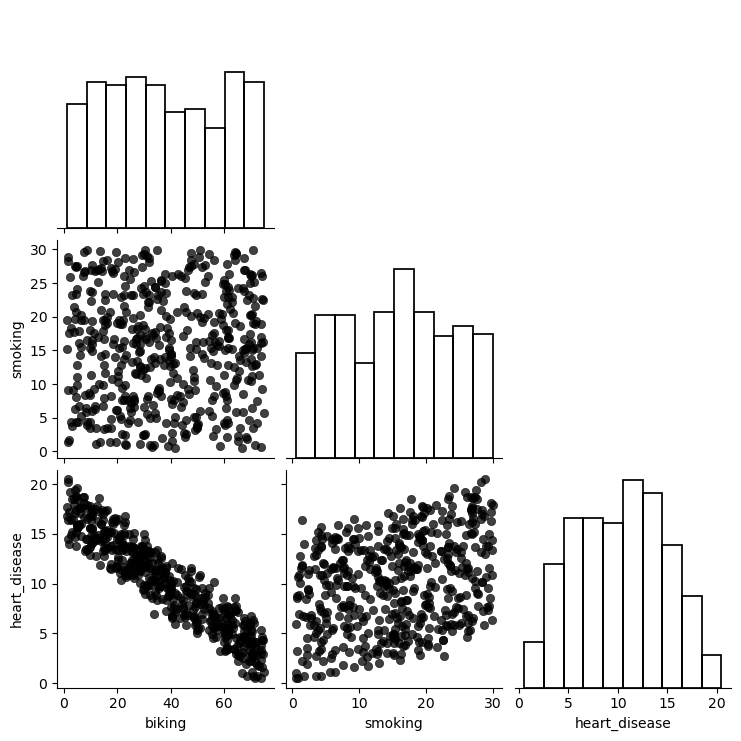

In [8]:
# Visualize relationships between numeric columns with a pairplot
sns.pairplot(
    data,
    corner=True,
    diag_kws={'fill': 0, 'color': 'black', 'bins': 10},
    plot_kws={'edgecolor': 'black', 
              'facecolor': 'black', 
              'marker': 'o', 
              'alpha': 0.75}
)
plt.show()

It seems that **heart disease** depends on both **biking** and **smoking**. Specifically, the pairplot shows a strong negative relationship between biking and heart disease, meaning that more time spent cycling is associated with a lower incidence of heart disease. On the other hand, there is a positive relationship between smoking and heart disease, which means that higher smoking levels are linked to an increase in heart disease. Meanwhile, there appears to be no relationship between biking and smoking.

It makes sense to try conducting a **multiple regression task** using biking and smoking as predictors and heart disease as the target variable.

## Visualize target variable distribution

It makes sense to analyze the statistical distribution of the target variable (in a linear regression model). Here’s why:

#### Identifying outliers

If the target variable has a heavy-tailed distribution (outliers), these points could disproportionately influence the regression coefficients. 

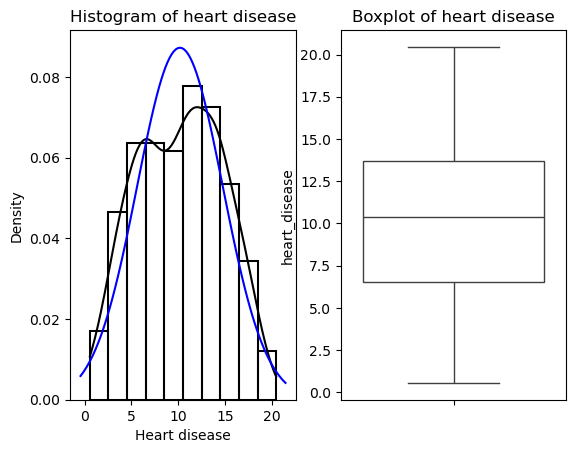

In [10]:
# Create the histogram with the KDE (Kernel Density Estimate) for smooth curve
plt.subplot(1, 2, 1)
sns.histplot(data['heart_disease'], kde=True, stat="density", bins=10,
             color='k', fill=False)

# Overlay the theoretical normal curve
mean = data['heart_disease'].mean()
std_dev = data['heart_disease'].std()
xmin, xmax = plt.xlim()
x = linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'b')

# Title and labels
plt.title('Histogram of heart disease')
plt.xlabel('Heart disease')
plt.ylabel('Density')

# Create the boxplot to visualize the distribution
plt.subplot(1, 2, 2)
sns.boxplot(data=data['heart_disease'], boxprops=dict(facecolor='none'))

plt.title('Boxplot of heart disease')
plt.show()

From the histogram, it can be seen that the target variable appears to be approximately normally distributed, and from the box plot, there are no outliers.

#### Skewness and kurtosis to quantify asymmetry and heavy tails

In [12]:
print(f"Skewness = {stats.skew(data['heart_disease'])}")

Skewness = -0.03333785644963169


$\text{Skewness} ≈ 0 \Rightarrow$ symmetric distribution (close to normal distribution). 

The distribution is almost symmetrical with a slight left skew, but it's negligible.

In [14]:
print(f"Kurtosis = {stats.kurtosis(data['heart_disease'])}")

Kurtosis = -0.9174267113283405


$\text{Kurtosis} ≈ 0 \Rightarrow$ similar to a normal distribution (mesokurtic).

The distribution has lighter tails (platykurtic), meaning fewer extreme values than a normal distribution.

Data for heart disease looks nearly normal in symmetry and has slightly flatter tails, but it’s not problematic for most models.

## Multicollinearity check

In [16]:
# Calculate the VIF for each feature
vif_data = []
for i in range(X.shape[1]):
    vif = variance_inflation_factor(X, i)
    vif_data.append(vif)

# Print the results
for i, vif in enumerate(vif_data):
    print(f"x{i+1}: VIF = {vif}")

x1: VIF = 2.4542649667806744
x2: VIF = 2.4542649667806744


The VIF results for features x1 and x2 are both around 2.45, indicating no severe multicollinearity between them. Since a VIF below 5 is considered acceptable, there's no need to remove these features. Therefore, we can continue with the model without concerns about multicollinearity.

## Model fit

In [18]:
# Fit of the linear regression model
model = OLS(y, add_constant(X)).fit()

# Visualization of the results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 1.190e+04
Date:                Mon, 24 Feb 2025   Prob (F-statistic):               0.00
Time:                        12:25:50   Log-Likelihood:                -493.68
No. Observations:                 498   AIC:                             993.4
Df Residuals:                     495   BIC:                             1006.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.9847      0.080    186.988      0.0

The regression model appears to be highly significant, with a strong predictive ability (R-squared 0.980). Both variables x1 and x2 are significant. Residual tests suggest that there are no serious violations of the model’s assumptions.

## Gauss Markov assumptions and residual analysis

### Zero mean 

In general, the mean of the residuals must be close to zero.

In [20]:
model.resid.mean()

7.56200100306934e-16

This is an ideal condition for a regression model, as it indicates that there are no systematic errors in the predictions.

### Normality of residuals

The **QQ plot** is useful for determining if the residuals follow a normal distribution. If the data points in the plot roughly follow a straight line at a 45-degree line, the data is normally distributed.

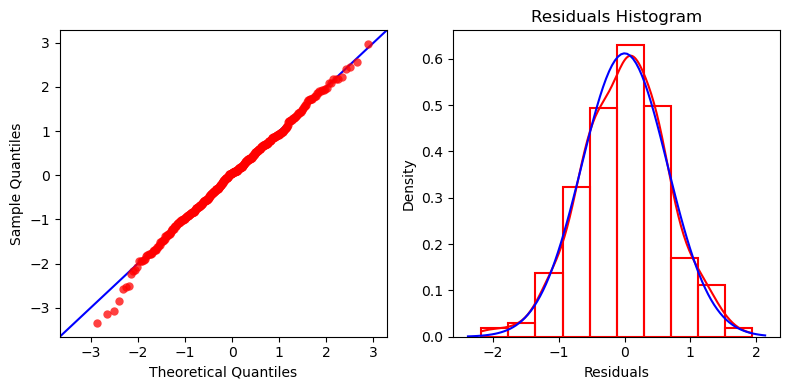

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# First plot: QQ plot
qqplot(model.resid, fit=True, line='45', ax=ax[0])
# Get the bisector line (45-degree line)
line = ax[0].get_lines()[1]
line.set_color('b')
# Place it behind the points
line.set_zorder(1)

points = ax[0].get_lines()[0]
points.set_markerfacecolor('r')
points.set_markeredgecolor('None')
points.set_alpha(0.75)
# Place the points above the bisector
points.set_zorder(2)

# Second plot: Histogram with density curve
sns.histplot(model.resid, kde=True, stat="density", bins=10,
             color='r', fill=False, ax=ax[1])
xmin, xmax = ax[1].get_xlim()
x = linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, model.resid.mean(), model.resid.std())
ax[1].plot(x, p, 'b')
ax[1].set_title('Residuals Histogram')
ax[1].set_xlabel('Residuals')
ax[1].set_ylabel('Density')

plt.tight_layout();

Since the data points closely follow the 45-degree line, the assumption of normality is likely met. This is further confirmed by a graph on the right, where the empirical distribution (in red) closely matches the theoretical normal distribution (in blue), indicating that the residuals follow a normal distribution.

### Homoscedasticity

The **Residuals vs. fitted values plot** is useful for confirming homoscedasticity. The x-axis shows the fitted values, and the y-axis shows the residuals. As long as the residuals appear randomly and uniformly distributed across the plot around the zero value, we can assume that homoscedasticity is not violated.

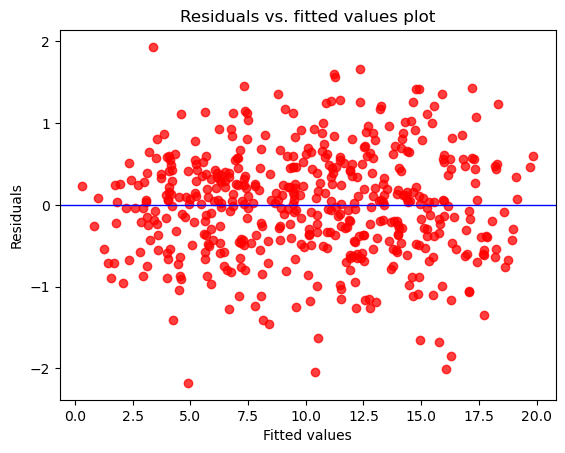

In [24]:
plt.scatter(model.fittedvalues, model.resid, color='r', marker='o', alpha=0.75)
plt.axhline(y=model.resid.mean(), color='b', lw=1)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. fitted values plot');

Since the residuals appear to be randomly scattered around zero, this indicates that heteroscedasticity is not an issue.

Since the residuals are normally distributed and homoscedastic, we have verified that the assumptions of the regression model are satisfied. Therefore, the output of our model is reliable.